Imports:

In [71]:
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier


# Data Retrieval 

In [72]:
dialogue = pd.read_csv(("https://raw.githubusercontent.com/"
 "rfordatascience/tidytuesday/master/data/"
 "2020/2020-09-08/friends.csv"))

print("Example Dialogue:")
dialogue.sample(4)


Example Dialogue:


,text,speaker,season,episode,scene,utterance
41342,Dude!,Joey Tribbiani,6,25,12,2
39828,[Joey's place. He goes to say something to Cha...,Scene Directions,6,20,9,51
58659,Are you kidding?,Ross Geller,9,13,14,7
9141,"Well, I don't know what to tell you dear. The ...",Mr. Adelman,2,11,5,34


In [73]:
episodes = pd.read_csv(("https://raw.githubusercontent.com/"
 "rfordatascience/tidytuesday/master/data/"
 "2020/2020-09-08/friends_info.csv"))

print("Example Episode:")
episodes.sample(4)

Example Episode:


,season,episode,title,directed_by,written_by,air_date,us_views_millions,imdb_rating
127,6,7,The One Where Phoebe Runs,Gary Halvorson,Sherry Bilsing-Graham & Ellen Plummer,1999-11-11,22.70,8.4
2,1,3,The One with the Thumb,James Burrows,Jeffrey Astrof & Mike Sikowitz,1994-10-06,19.50,8.2
177,8,8,The One with the Stripper,David Schwimmer,Andrew Reich & Ted Cohen,2001-11-15,26.54,8.8
212,9,19,The One with Rachel's Dream,Terry Hughes,Story by : Dana Klein BorkowTeleplay by : Mark...,2003-04-17,18.25,8.1


# Preprocessing

In [74]:


# 6 Main Character Names
main_character_names = ["Ross Geller", "Monica Geller",
                        "Phoebe Buffay", "Chandler Bing",
                        "Joey Tribbiani", "Rachel Green"]


#Filters Out Non Dialogue Rows
all_dialogue = dialogue[~dialogue["speaker"].isin(["Scene Directions", "#ALL#", "NA"])]


#Indexs of  MAIN CHARACTER DIALOGUE
dialogue_mc_indexs = all_dialogue["speaker"].isin(main_character_names)

#Indexs of OTHER CHARACTER DIALOGUE
dialogue_oc_indexs = ~all_dialogue["speaker"].isin(main_character_names)

#Indexs of EXCLAMATORY DIALOGUE
dialogue_exclamatory_indexs = all_dialogue["text"].str.contains(r'[A-Z]{2,}') | all_dialogue["text"].str.contains(r'!')

In [75]:
#FUNCTION TO APPLY

def sum_size(x):
    return x.str.len().sum()
                      

# Processing 1/4: Adding Episode Level Dialogue Info


In [76]:

#Table To Store Episode Level Dialogue Summary
jt_1 = all_dialogue.groupby(["season", "episode"]).agg("first").reset_index().drop(columns=["scene", "utterance", "speaker", "text"])

jt_1.head(2)

,season,episode
0,1,1
1,1,2


In [77]:
#Grouped Data
gp = all_dialogue.groupby(["season", "episode"])

#Adding Total Words In Episode
jt_1 = pd.merge(jt_1, gp["text"].size().reset_index(name="total_words"))

#Adding Total Lines In Episode
jt_1 = pd.merge(jt_1, gp["text"].agg(sum_size).reset_index(name="total_lines"))

#Adding Total Scenes In Episode
jt_1 = pd.merge(jt_1, gp["scene"].nunique().reset_index(name="total_scenes"))

#Adding Total Speakers In Episode
jt_1 = pd.merge(jt_1, gp["speaker"].nunique().reset_index(name="total_speakers"))

jt_1.head(5)

,season,episode,total_words,total_lines,total_scenes,total_speakers
0,1,1,292,16876,15,11
1,1,2,241,12249,11,14
2,1,3,237,12070,14,10
3,1,4,248,12532,16,14
4,1,5,238,12626,16,10


In [78]:

#Grouped Data (All NON-MAIN Characters Lines By Episodes)
gp = all_dialogue[dialogue_oc_indexs].groupby(["season", "episode"])


# Adding Total Lines By NON-MAIN characters
jt_1 = pd.merge(jt_1, gp["text"].size().reset_index(name="oc_lines"))

#Adding Total Scenes By NON-MAIN characters
jt_1 = pd.merge(jt_1, gp["scene"].nunique().reset_index(name="oc_scenes"))


#Grouped Data (All NON-MAIN Characters Exclamatory Lines By Episode)
gp = all_dialogue[dialogue_oc_indexs & dialogue_exclamatory_indexs].groupby(["season", "episode"])

#Adding Total Exclamatory Lines By Non Main Characters
jt_1 = pd.merge(jt_1, gp["text"].size().reset_index(name="oc_exclam"))

jt_1.head(5)

,season,episode,total_words,total_lines,total_scenes,total_speakers,oc_lines,oc_scenes,oc_exclam
0,1,1,292,16876,15,11,27,9,5
1,1,2,241,12249,11,14,69,8,19
2,1,3,237,12070,14,10,24,6,3
3,1,4,248,12532,16,14,31,6,10
4,1,5,238,12626,16,10,34,10,2


# Processing 2/4: Adding Character Level Dialogue Info

In [79]:
#Table To Store Character Level Dialogue Summary
# (WILL BE PIVOTED INTO ABOVE FORM BELOW)

jt_2 = all_dialogue[dialogue_mc_indexs].groupby(["season", "episode", "speaker"]).agg("first").reset_index().drop(columns=["scene", "utterance", "text"])

jt_2.head(6)

,season,episode,speaker
0,1,1,Chandler Bing
1,1,1,Joey Tribbiani
2,1,1,Monica Geller
3,1,1,Phoebe Buffay
4,1,1,Rachel Green
5,1,1,Ross Geller


In [80]:
#Grouped Data (All Main Character Dialogue By Episode, Speaker)
gp = all_dialogue[dialogue_mc_indexs].groupby(["season", "episode", "speaker"])

#Adding Total Lines Per Main Character
jt_2 = pd.merge(jt_2, gp["text"].size().reset_index(name="lines"))

#Adding Total Scenes Per Main Character 
jt_2 = pd.merge(jt_2, gp["scene"].nunique().reset_index(name="scene"))



#Grouped Data (All Main Character Exclamatory Lines, By Episode, Speaker)
gp = all_dialogue[dialogue_mc_indexs & dialogue_exclamatory_indexs].groupby(["season", "episode", "speaker"])

#Adding Total Exclamatory Lines By Main Character
jt_2 = pd.merge(jt_2, gp["text"].size().reset_index(name="exclam_lines"))


jt_2.head(6)

,season,episode,speaker,lines,scene,exclam_lines
0,1,1,Chandler Bing,39,9,8
1,1,1,Joey Tribbiani,39,8,11
2,1,1,Monica Geller,73,9,20
3,1,1,Phoebe Buffay,19,6,5
4,1,1,Rachel Green,48,8,15
5,1,1,Ross Geller,47,8,8


In [81]:

#Pivoting Table (To Ensure One Row Per Episode)
jt_2 = jt_2.pivot(index=["season", "episode"], columns="speaker", values=["lines", "scene", "exclam_lines"]).reset_index(inplace=False)

#Renaming Columns + Reseting Index
jt_2.columns = ['_'.join(map(str, col)).strip() for col in jt_2.columns.values]
jt_2.reset_index(inplace=False)
jt_2.rename(columns={"season_":"season", "episode_":"episode"}, inplace=True)


jt_2.head(2)

,season,episode,lines_Chandler Bing,lines_Joey Tribbiani,lines_Monica Geller,lines_Phoebe Buffay,lines_Rachel Green,lines_Ross Geller,scene_Chandler Bing,scene_Joey Tribbiani,scene_Monica Geller,scene_Phoebe Buffay,scene_Rachel Green,scene_Ross Geller,exclam_lines_Chandler Bing,exclam_lines_Joey Tribbiani,exclam_lines_Monica Geller,exclam_lines_Phoebe Buffay,exclam_lines_Rachel Green,exclam_lines_Ross Geller
0,1,1,39.0,39.0,73.0,19.0,48.0,47.0,9.0,8.0,9.0,6.0,8.0,8.0,8.0,11.0,20.0,5.0,15.0,8.0
1,1,2,16.0,8.0,28.0,14.0,38.0,68.0,4.0,4.0,5.0,4.0,6.0,9.0,2.0,1.0,5.0,9.0,8.0,10.0


# Processing 3/4: Adding Episode Review/Viewership Info

In [82]:
#Taking Existing Episode df and dropping certain attributes
jt_3 = episodes.drop(columns=["title", "directed_by", "written_by", "air_date"])

jt_3.head(6)

,season,episode,us_views_millions,imdb_rating
0,1,1,21.5,8.3
1,1,2,20.2,8.1
2,1,3,19.5,8.2
3,1,4,19.7,8.1
4,1,5,18.6,8.5
5,1,6,18.2,8.1


# Processing 4/4: Joining Tables + Summary

In [83]:
#JOINING ALL STATISTICS INTO A SINGLE DATA TO CREATE A MODEL FROM

joined_table_final = pd.merge(pd.merge(jt_1, jt_2, on=["season", "episode"]), jt_3, on=["season", "episode"])

joined_table_final.head(2)

,season,episode,total_words,total_lines,total_scenes,total_speakers,oc_lines,oc_scenes,oc_exclam,lines_Chandler Bing,...,scene_Rachel Green,scene_Ross Geller,exclam_lines_Chandler Bing,exclam_lines_Joey Tribbiani,exclam_lines_Monica Geller,exclam_lines_Phoebe Buffay,exclam_lines_Rachel Green,exclam_lines_Ross Geller,us_views_millions,imdb_rating
0,1,1,292,16876,15,11,27,9,5,39.0,...,8.0,8.0,8.0,11.0,20.0,5.0,15.0,8.0,21.5,8.3
1,1,2,241,12249,11,14,69,8,19,16.0,...,6.0,9.0,2.0,1.0,5.0,9.0,8.0,10.0,20.2,8.1


#### THE ABOVE TABLE CONTAINS THE FOLLOWING: ON PER EPISODE BASIS

     "total_words" -       The Number Of Words Spoken

     "total_lines" -       The Number Of Lines Spoken

     "total_scenes" -      The Number Of Scenes

     "total_speakers" -    The Number Of Total Characters Who Speak

     "oc_lines" -          The Number Of Lines Collectively Spoken By All Non-Main Characters

     "oc_scenes" -         The Number Of Scenes In Which A Non-Main Character Speaks

     "oc_exclam" -         The Number Of Exclamatory Lines (upper case word, or exclamation point)
                           Collectively Spoken By All Non-Main Characters

     "us_views_millions" - The Number Of Viewers This Episode Had When Released (EXISTING NOT DERIVED)

     "imdb_rating" -       The Rating Given To The Episode By IMDB (EXISTING NOT DERIVED)


     COL: For All 6 Main Character Names (MCN)

          "lines_{MCN}" -         The Number Of Lines Spoken By This Main Character

          "scenes_{MCN}" -        The Number Of Scenes Spoken In By This Main Character

          "exclam_lines_{MCN} -   The Number Of Exclamatory Lines (Upper Case Word, or Exclamation point)
                                   Spoken By This Main Character

# Inference Task

In [86]:
# I want to verify that use of exclamatory speech really does impact episode IMDb rating 

# Resampling import to use in bootstrapping 
from sklearn.utils import resample

# Combining columns with exclamation
exclam_cols = ['exclam_lines_Chandler Bing','exclam_lines_Joey Tribbiani','exclam_lines_Monica Geller','exclam_lines_Phoebe Buffay','exclam_lines_Rachel Green','exclam_lines_Ross Geller']
exclam = joined_table_final['oc_exclam'] 
for col_name in exclam_cols:
    exclam = exclam + joined_table_final.loc[:,col_name]

# Creates new dataframe with the desired columns (rating and # of exclamations)
df_exclam = pd.DataFrame({"Exclamations":exclam, "Rating":joined_table_final['imdb_rating']})
mean_exclam = np.round(np.mean(df_exclam), 0)
df_exclam.fillna({'Exclamations':mean_exclam}, inplace=True)

# Defines two populations: IMDb ratings with high exclamation use and ratings with low exclamation use 
df_exclam 
mean_exclamation = np.mean(df_exclam['Exclamations'])
pop1 = df_exclam[df_exclam['Exclamations']>mean_exclamation]['Rating']
pop2 = df_exclam[df_exclam['Exclamations']<=mean_exclamation]['Rating']

# Define number of bootstrap resamples
n_resamples = 1000
mean_diffs = np.zeros(n_resamples)

# Bootstrapping procedure (add difference in each resampled mean to the list)
for i in range(n_resamples):
    s1 = resample(pop1, replace=True)
    s2 = resample(pop2, replace=True)
    mean_diffs[i] = np.mean(s1)-np.mean(s2) 
    
# Confidence interval 
ci_95 = np.percentile(mean_diffs, [2.5, 97.5]) 

# Mean Difference 
mean_difference = round(np.mean(mean_diffs),2)

print(f'On average, episodes with more exclamation have about {mean_difference*100}% higher imdb ratings.')
print(f'The mean difference between ratings is on a 95% confidence interval of being in the range({round(ci_95[0],2)*100}%, {round(ci_95[1],2)*100}%)')


On average, episodes with more exclamation have about 12.0% higher imdb ratings.
The mean difference between ratings is on a 95% confidence interval of being in the range(3.0%, 22.0%)


It seems that the hypothesis was correct. Episodes with more exclamatory speech tend to have **13%** higher ratings on average! This clearly demonstrates that emphatic speech significantly impacts episode IMDb rating.    

# Prediction Task

In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

features = ['Episode_Dialogue', 'Episode_Exclaim', 'Speaker_Dialogue', 'Speaker_Exclaim', 'us_views_millions', 'imdb_rating']
X = master_list[features]
y = master_list['Speaker_Exclaimed_Toward']  # Target variable

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42)
}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, scoring='neg_mean_squared_error', cv=kfold)
    rmse_scores = np.sqrt(-scores)
    print(f"{name} RMSE: {rmse_scores.mean():.4f} (±{rmse_scores.std():.4f})")

KeyError: "['Episode_Dialogue', 'Episode_Exclaim', 'Speaker_Dialogue', 'Speaker_Exclaim'] not in index"

Based on the RMSE values, the Linear Regression model seems to perform slightly better in this case compared to the Random Forest model.

In [ ]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_scaled, y)

feature_importances = pd.Series(rf_model.feature_importances_, index=features)
feature_importances_sorted = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(feature_importances_sorted.index, feature_importances_sorted.values)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importances')
plt.show()

features = ['Speaker_Exclaimed_Toward']
X = master_list[features]
y = master_list['imdb_rating']  # Target variable

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LinearRegression()

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X_scaled, y, scoring='neg_mean_squared_error', cv=kfold)
rmse_scores = np.sqrt(-scores)
print(f"Linear Regression RMSE: {rmse_scores.mean():.4f} (±{rmse_scores.std():.4f})")

model.fit(X_scaled, y)

# Example to show off our predictions
new_episode_emphatic_speeches = [[15]]
new_episode_emphatic_speeches_scaled = scaler.transform(new_episode_emphatic_speeches)
predicted_rating = model.predict(new_episode_emphatic_speeches_scaled)
print("Predicted Rating for the New Episode:", predicted_rating[0])

NameError: name 'X_scaled' is not defined

In [ ]:

# showing off our predictive ratings using a sample of 20 different exclamation values
new_episodes = np.random.randint(0, 50, size=20).reshape(-1, 1)
new_episodes_scaled = scaler.transform(new_episodes)

predicted_ratings = model.predict(new_episodes_scaled)

predicted_ratings_rounded = np.round(predicted_ratings, 2)

results_df = pd.DataFrame({
    'Speaker_Exclaimed_Toward': new_episodes.flatten(),
    'Predicted_Rating': predicted_ratings_rounded
})

print("Automated Predictions for 20 Different Values of Speaker_Exclaimed_Toward:")
print(results_df)

NameError: name 'scaler' is not defined

# Regression and Classification

1.4169598260683805e-05
0.1673918182409587


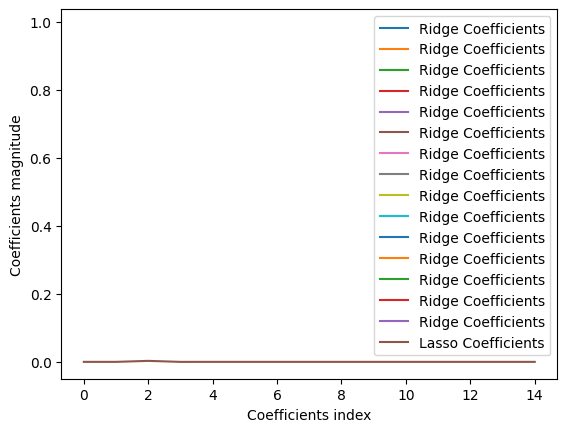

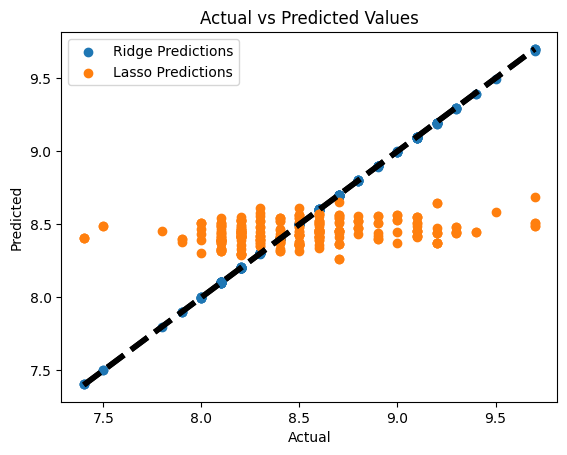

In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming X_train, X_test, y_train, y_test are your training and testing data
# Split the data into training and testing sets
X = joined_table_final.loc[:, joined_table_final.columns != 'speaker'].reset_index(drop=True)
y = joined_table_final[['imdb_rating']].reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ridge Regression
ridge_reg = Ridge(alpha=1.0)  # Alpha is the regularization parameter
ridge_reg.fit(X_train, y_train)
ridge_pred = ridge_reg.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)
print(ridge_mse)

# Lasso Regression
lasso_reg = Lasso(alpha=1.0)  # Alpha is the regularization parameter
lasso_reg.fit(X_train, y_train)
lasso_pred = lasso_reg.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_pred)
print(lasso_mse)

ridge_coefficients = ridge_reg.coef_
lasso_coefficients = lasso_reg.coef_

# Plot Ridge coefficients
plt.plot(range(len(ridge_coefficients)), ridge_coefficients, label='Ridge Coefficients')

# Plot Lasso coefficients
plt.plot(range(len(lasso_coefficients)), lasso_coefficients, label='Lasso Coefficients')

plt.xlabel('Coefficients index')
plt.ylabel('Coefficients magnitude')
plt.legend()
plt.show()

ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# Actual vs Predicted plot for Ridge
plt.scatter(y_test, ridge_pred, label='Ridge Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

# Actual vs Predicted plot for Lasso
plt.scatter(y_test, lasso_pred, label='Lasso Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.94      1.00      0.97       252

    accuracy                           0.94       268
   macro avg       0.47      0.50      0.48       268
weighted avg       0.88      0.94      0.91       268

[[  0  16]
 [  0 252]]


c:\Users\bmvan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\bmvan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bmvan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.p

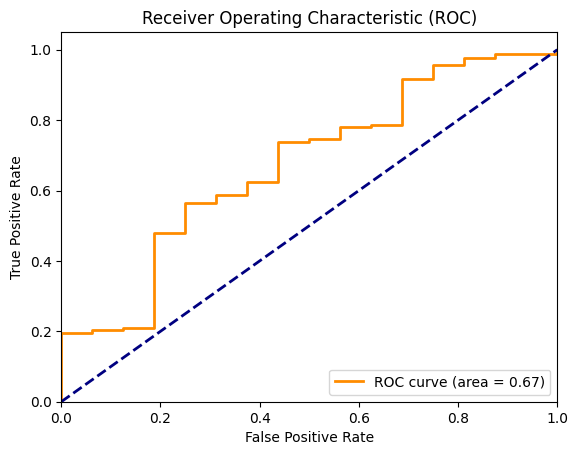

c:\Users\bmvan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.94      1.00      0.97       252

    accuracy                           0.94       268
   macro avg       0.47      0.50      0.48       268
weighted avg       0.88      0.94      0.91       268



c:\Users\bmvan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bmvan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


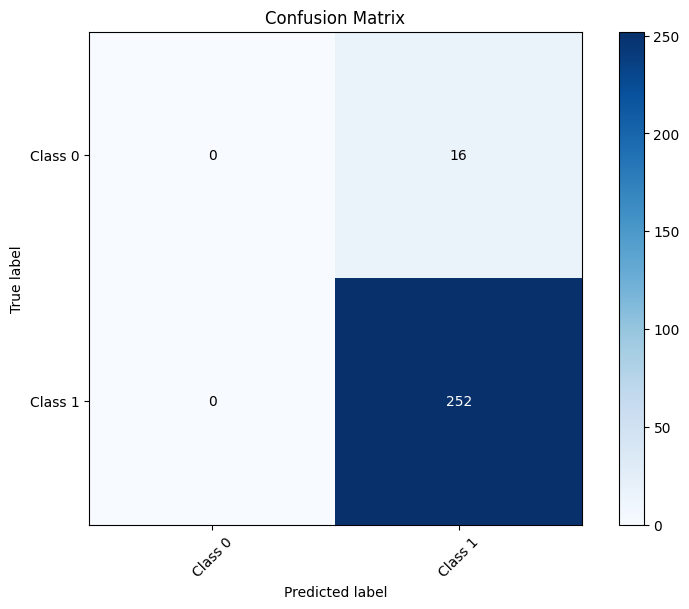

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
joined_table_final['high_rating'] = np.where(joined_table_final['imdb_rating'] > 8.0, 1, 0)

# Define the features and the target.
X = joined_table_final.loc[:, joined_table_final.columns != 'speaker']
X = X.drop(['imdb_rating', 'high_rating'], axis=1)  # Drop the original 'imdb_rating' and the new binary target column from the features.
y = joined_table_final['high_rating']

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Logistic Regression classifier.
log_reg = LogisticRegression()

# Fit the classifier to the training data.
log_reg.fit(X_train, y_train)

# Predict on the testing set.
y_pred = log_reg.predict(X_test)

# Evaluate the classifier.
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

# Assume log_reg is your trained Logistic Regression model, and X_test and y_test are your test dataset.

# Get predicted probabilities
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Display the classification report
print(classification_report(y_test, log_reg.predict(X_test)))

# Compute and plot the confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming log_reg is your trained Logistic Regression model
# and y_test, y_pred are your test labels and predictions respectively

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Adding the text labels
classes = ['Class 0', 'Class 1']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Labeling the plot
thresh = cm.max() / 2. # for text color
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")  # text color

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()